In [1]:
import numpy as np
import argparse
import os
from distutils.util import strtobool
from sklearn import svm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from scipy.linalg import sqrtm

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch
import sys
from util.nets import *
import random
import scipy.io as sio

from util.dataUtil import *
from util.modelUtil import *
from util.preproc import *
from os.path import join

In [206]:
typeTest = 'trainTestSession'
info = {
            'bandL': float(13),
            'bandR': float(30),
            'windowSize': 128,
            'EA': str(True),
            'channelType': channelCombos[-1],
            'modelName': 'SVM', 
            'typeTest': typeTest,
            'numSub': 5, 
            'input': './dataShu',
            'dataset': 'shu',
            'numChan': -1
        }

In [60]:
print(len(PreProDatas))

4


In [ ]:
PreProDatas = np.load('./shutest.npy', allow_pickle=True)

In [9]:
def matmul_list(matrix_list, db=False):
    if db:
        for x in matrix_list:
            print(x.shape)
    number_matrix = len(matrix_list)
    result = np.copy(matrix_list[0])
    for i in range(1, number_matrix):
        result = np.matmul(result, matrix_list[i])
    return result

In [10]:

def chunk(matrix, size):
    list_matrix = []

    l, r = matrix.shape[0]-1 - size, matrix.shape[0]-1
    
    while l >= 0:
        subMatrix = np.copy(matrix[l:r])
        list_matrix.append(subMatrix)
        l -= size
        r -= size
    return list_matrix

def chunk_matrix(list_data, label, size):
    list_matries = []
    list_ys = []
    for idx, matrix in enumerate(list_data):
        matries = chunk(matrix, size)
        list_matries.extend(matries)
    y_matries = [label] * len(list_matries)

    return list_matries, y_matries

In [57]:

def preprocessDataInfo(inputData, info):
    result = []
    numberSub = len(inputData)
    for subId in range(numberSub):
        numberSample = len(inputData[subId])
        subData = inputData[subId]
        preprocSub = []
        for sampleId in range(numberSample):
            if info['dataset'] == 'shu':
                scenarioId, listEEG = subData[sampleId]
            else:
                scenarioId, listEEG, _ = subData[sampleId]
            # print(scenarioId)
            newData, label = chunk_matrix(listEEG, scenarioId, size=int(info['windowSize']))
            preprocSub.append([newData, label])
            # break
        result.append(preprocSub)
    """
    result comprises [dataSub1,dataSub2...]
    dataSubx comprises [[data, scenarioID], [data, scenarioID]]
    """
    return result


In [12]:
def getData_All(inputData):
    data, label = [], []
    for id, dataSub in enumerate(inputData):
        for dataSample, _ in dataSub:
            data.extend(dataSample)
            label.extend([id]*len(dataSample))
    return np.asarray(data), np.asarray(label)


def trainTestSplit(data, target, test, testIndex):
    X_train = []
    X_test= []
    y_train = []
    y_test = []
    for idx in range(len(data)):
        if test[idx] == testIndex:
            X_test.append(data[idx])
            y_test.append(target[idx])
        else:
            X_train.append(data[idx])
            y_train.append(target[idx])
    return X_train, y_train, X_test, y_test


In [14]:
def getDataScenario(inputData, testIndex):
    data, label, test = [], [], []
    for id, dataSub in enumerate(inputData):
        for dataSample, scenarioId in dataSub:
            subLabel = [id] * len(dataSample)
            data.extend(dataSample)
            label.extend(subLabel)
            testLabel = []
            if len(scenarioId) > 0 and scenarioId[0] == testIndex:
                testLabel = [1] * len(dataSample)
                test.extend(testLabel)
            else:
                testLabel = [0] * len(dataSample)
                test.extend(testLabel)
    X_train, y_train, X_test, y_test = trainTestSplit(data, label, test, 1)
    return np.asarray(X_train), y_train, np.asarray(X_test), y_test


In [15]:
def listRepresent(X_train, y_train, reverse = False):
    tmp = []
    for label in np.unique(y_train):
        tmplist = X_train[np.where(y_train == label)]
        meanMat = np.mean( tmplist, axis = 0)
        if reverse:
            meanMat = meanMat.T
        tmp.append(meanMat)
    return np.hstack(tmp)

In [16]:
def getV_SVD(matrix):
    tmpMat = np.matmul(matrix, matrix.T)
    _, Sigma_mean, UmeanMat = np.linalg.svd(tmpMat , full_matrices=False)
    UmeanMat = UmeanMat.T
    return UmeanMat

In [17]:

def getNormR(data, shapeIn = 32):
    print(data.shape)
    normR = np.zeros([shapeIn, shapeIn])
    for ii in range(len(data)):
        covX = np.matmul(data[ii].T, data[ii])
        normR += covX
    normR = normR / len(data)
    normR = np.linalg.inv(normR)
    
    print(f"norm shape{normR.shape}")
    return normR

def applyNorm(X_train, normMat):
    tmp = [np.matmul(X, normMat) for X in X_train]
    return np.asarray(tmp)

def randomSymmetricMat(shapeIn = 64):
    tmp = np.random.rand(shapeIn, shapeIn)
    return np.matmul(tmp, tmp.T)

In [133]:
def normMat(X_train, X_test):
    mean = np.mean(X_train, axis=0, keepdims=True)
    std = np.std(X_train, axis=0, keepdims=True)
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std
    return X_train, X_test, mean, std 

def normMat1Input(X_train):
    mean = np.mean(X_train, axis=0, keepdims=True)
    std = np.std(X_train, axis=0, keepdims=True)
    X_train = (X_train - mean) / std
    return X_train

In [19]:
def transformMat(X, Basis, reverse = False):
    tmp = []
    for ii in range(len(X)):
        Xnew = np.copy(X[ii])
        if reverse:
            Xnew = Xnew.T
        U_Test = getV_SVD(Xnew)

        transformMatrix = np.matmul( U_Test, Basis.T)
        Xnew = matmul_list([ Basis.T, transformMatrix, U_Test, Xnew])
        tmp.append(Xnew)
    return np.asarray(tmp)

def EANorm(X_train, X_test, refer):
    normR = getNormR(refer, refer.shape[-1])
    X_train = applyNorm(X_train, normR)
    X_test = applyNorm(X_test, normR)
    return X_train, X_test

In [249]:
channelCombos = [
    ['Fz', 'Fp1', 'F7', 'F3', 'FC1', 'FC5', 'FC6', 'FC2', 'F4', 'F8', 'Fp2'],
    ['Cz', 'C3', 'CP5', 'CP1', 'CP2', 'CP6', 'C4'],
    ["Fp1", "Fp2", "Fz", "F3", "F4", "F7", "F8", "FC1", "FC2", "FC5",
            "FC6", "Cz", "C3", "C4", "T3", "T4", "A1", "A2", "CP1", "CP2",
            "CP5", "CP6", "Pz", "P3", "P4", "T5", "T6", "PO3", "PO4", "Oz",
            "O1", "O2"]
]

listChns = ["Fp1", "Fp2", "Fz", "F3", "F4", "F7", "F8", "FC1", "FC2", "FC5",
            "FC6", "Cz", "C3", "C4", "T3", "T4", "A1", "A2", "CP1", "CP2",
            "CP5", "CP6", "Pz", "P3", "P4", "T5", "T6", "PO3", "PO4", "Oz",
            "O1", "O2"]

listMethods = ['PSD + SVM', 'IHAR + SVM']
event_id = {'left': 1,'right':2}

def get_dataShu(subj,session,data_path):
    da=sio.loadmat(join(data_path,'sub-'+str(subj).zfill(3)+'_ses-'+str(session).zfill(2)+'_task_motorimagery_eeg.mat'))
    data=da['data']
    labels=np.ravel(da['labels'])
    return data,labels

def mnebandFilter(data,labels,dataInfo):
    si,sj,sk=data.shape
    da=data.transpose(1,0,2)
    da=da.reshape(sj,si*sk)
    llen=data.shape[0]
    event=np.zeros((llen,3))
    info = mne.create_info(
        ch_names=listChns,
        ch_types="eeg",  # channel type
        sfreq=128  # frequency
    )
    raw = mne.io.RawArray(da, info)  # create raw
    raw.filter(dataInfo['bandL'], dataInfo['bandR'], fir_design='firwin')
    for i in range(llen):
        event[i,0]=i*sk
        event[i,2]=labels[i]
    event=event.astype(int)
    train_epoches = mne.Epochs(raw, event, event_id, 1.5, 3.5 + 0.004,
                               baseline=None, preload=True)
    train_data = train_epoches.get_data()
    tmp = np.asarray(event)
    train_data = train_data[np.where(tmp[:,2] == 1)]
    return train_data


def extractDataShu_byInfo(info):
    # info['numSub']
    listData = []
    dss = [0,4]
    for idx in range(info['numSub']):
        subData = []
        for ts in range(2):
            ss = dss[ts]
#             ss = ts
            data, label = get_dataShu(idx+1, ss+1, info['input'])
            train_data  = mnebandFilter(data, label, info)
            transposeData = [x.T for x in train_data]
            transposeData = normMat1Input(np.asarray(transposeData))
#             subData.append([ts, transposeData])
            listData.append([[1, transposeData]])
#         listData.append(subData)
    return listData

def trainCore(X_train, X_test, y_train, y_test, info):
    X_train, X_test, _, _ = normMat(X_train, X_test)

    if args.eaNorm == 'DEA':    
        allMat = listRepresent(X_train, y_train, True)
        UmeanMat = getV_SVD(allMat)
        
        X_train = transformMat(X_train, UmeanMat, True)
        X_test = transformMat(X_test, UmeanMat, True)

        X_train, X_test = EANorm(X_train, X_test, X_train)

    elif args.eaNorm == 'EA':
        X_train, X_test = EANorm(X_train, X_test, X_train)

    if args.modelFeatures == 'PSD':
        X_train, y_train, X_test, y_test = PSD(X_train, y_train, X_test, y_test)
    elif args.modelFeatures == 'IHAR':
        X_train, y_train, X_test, y_test = IHAR(X_train, y_train, X_test, y_test, listChns)           
    elif args.modelFeatures == 'APF':
        X_train = np.mean(np.log(np.abs(X_train)), axis = 1)
        X_test = np.mean(np.log(np.abs(X_test)), axis = 1)

    if args.modelName == 'SVM':
        return SVM(X_train, y_train, X_test, y_test)

    elif (info['modelName'] == 'CNN' or info['modelName'] == "CNN_LSTM"):
        n_samples, n_timestamp, n_channels = X_train.shape
        X_train = X_train.reshape((n_samples, n_timestamp, n_channels, 1))
        X_train = np.transpose(X_train, (0, 3, 1, 2))

        n_samples, n_timestamp, n_channels = X_test.shape
        X_test = X_test.reshape((n_samples, n_timestamp, n_channels, 1))
        X_test = np.transpose(X_test, (0, 3, 1, 2))
        trainLoader, validLoader = TrainTestLoader([X_train, y_train, X_test, y_test])
        num_class = len(np.unique(y_train))

        listModelName = []
        model = chooseModel(str(args.modelName), num_class=num_class+1, input_size=(1, X_train.shape[2], X_train.shape[3]))
        print("Model architecture >>>", model)
        model.to(device)
        criterion = nn.CrossEntropyLoss()
        lr = 3e-4
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = lr_scheduler.StepLR(optimizer, 16, gamma=0.1, last_epoch=-1)
        n_epochs = 10
        _, llos, acc, accTrain = trainModel(model, criterion, n_epochs, optimizer, scheduler, trainLoader,
                                            validLoader, n_class=num_class, log_batch=max(len(trainLoader) // 30, 1))
        return acc
    elif info['modelName'] == 'SHALLOW':
        n_samples, n_timestamp, n_channels = X_train.shape
        X_train = X_train.reshape((n_samples, n_timestamp, n_channels, 1))
        X_train = np.transpose(X_train, (0, 2, 1, 3))
        # X_train, y_train = augmentData(X_train, y_train, np.unique(y_train))
        n_samples, n_timestamp, n_channels = X_test.shape
        X_test = X_test.reshape((n_samples, n_timestamp, n_channels, 1))
        X_test = np.transpose(X_test, (0, 2, 1, 3))
        trainLoader, validLoader = TrainTestLoader([X_train, y_train, X_test, y_test])
        num_class = len(np.unique(y_train))
        input_time_length = X_train.shape[2]
        in_chans = X_train.shape[3]
        model = EEGShallowClassifier(in_chans=32, n_classes=num_class, input_time_length=128, return_feature=False)
        print("Model architecture >>>", model)
        model.to(device)
        criterion = nn.CrossEntropyLoss()
        lr = 3e-3
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.5 * 0.001)
        scheduler = lr_scheduler.StepLR(optimizer, 16, gamma=0.1, last_epoch=-1)
        n_epochs = 20

        _, llos, acc, accTrain = trainModel(model, criterion, n_epochs, optimizer, scheduler, trainLoader,
                                            validLoader, n_class=num_class, log_batch=len(trainLoader) // 30)
        return acc
    else:
        pass
    return

In [250]:
# normal
datas = extractDataShu_byInfo(info)
print("Number of subjects in data: ", len(datas))
PreProDatas = preprocessDataInfo(datas, info)
np.save('./shutest.npy', PreProDatas)


Creating RawArray with float64 data, n_channels=32, n_times=100000
    Range : 0 ... 99999 =      0.000 ...   781.242 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 131 samples (1.023 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 100 events and 258 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=94000
    Range : 0 ... 93999 =      0.000 ...   734.367 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 131 samples (1.023 sec)



[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 94 events and 258 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=92000
    Range : 0 ... 91999 =      0.000 ...   718.742 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 131 samples (1.023 sec)



[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
92 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 92 events and 258 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=95000
    Range : 0 ... 94999 =      0.000 ...   742.180 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 131 samples (1.023 sec)



[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
95 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 95 events and 258 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=92000
    Range : 0 ... 91999 =      0.000 ...   718.742 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 131 samples (1.023 sec)



[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
92 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 92 events and 258 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=100000
    Range : 0 ... 99999 =      0.000 ...   781.242 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 131 samples (1.023 sec)



[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 100 events and 258 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=87000
    Range : 0 ... 86999 =      0.000 ...   679.680 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 131 samples (1.023 sec)



[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 87 events and 258 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=100000
    Range : 0 ... 99999 =      0.000 ...   781.242 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 131 samples (1.023 sec)



[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 100 events and 258 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=94000
    Range : 0 ... 93999 =      0.000 ...   734.367 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 131 samples (1.023 sec)



[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 94 events and 258 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=89000
    Range : 0 ... 88999 =      0.000 ...   695.305 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 131 samples (1.023 sec)



[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
89 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 89 events and 258 original time points ...
0 bad epochs dropped
Number of subjects in data:  10


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.2s finished
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [63]:
def vis(info, t = 0):
    print('info')
    X0, y0, X1, y1 = info
    X2 = np.vstack([X0, X1])
    y2 = np.hstack([y0, y1])
    visData = [[X0, y0], [X1, y1], [X2, y2]]
    
    embeddings = visData[t][0]

    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2)
    transformed = tsne.fit_transform(embeddings)

    import seaborn as sns
    palette = sns.color_palette("bright", len(np.unique(y0)))
    g = sns.scatterplot(
        x=transformed[:,0],
        y=transformed[:,1],
        hue=visData[t][1],
        legend='full',
        palette=palette
    )
#     _lg = g.get_legend()
#     _lg.remove()

def vis2(info, t = 0):
    print('info')
    X0, y0, X1, y1 = info
    visData = [[X0, y0], [X1, y1]]
    
    
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2)
    transformed2 = tsne.fit_transform(visData[1][0])
    transformed1 = tsne.fit_transform(visData[0][0])

    import seaborn as sns
    palette = sns.color_palette("bright", len(np.unique(y0)))
    sns.scatterplot(
        x=transformed1[:,0],
        y=transformed1[:,1],
        hue = y0,
        legend='full',
        palette=palette
    )

    ax = sns.scatterplot(
        x=transformed2[:,0],
        y=transformed2[:,1],
        hue = y1+1,
        marker="+",
        palette='deep'
    )
    handles, labels  =  ax.get_legend_handles_labels()

    ax.legend(handles, ['0 with SF', '1 with SF', '2 with SF', '3 with SF', '0 without SF', '1 without SF', '2 without SF', '3 without SF'], loc='lower right')
    ax.set(xlim=(-70, 70))

Training at 0 round
(747, 128, 32)
norm shape(32, 32)
info


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


NameError: name 'acc' is not defined

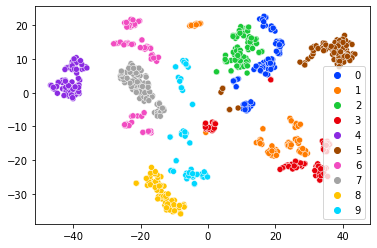

In [251]:
# # normal
# datas = extractDataShu_byInfo(info)
# print("Number of subjects in data: ", len(datas))
# PreProDatas = preprocessDataInfo(datas, info)
# np.save('./shutest.npy', PreProDatas)

listSeed = [x*500+15 for x in range(50)]
numberTest = 1
listAcc = []
typeTest = 'trainTestRandom'
for testingTime in range(numberTest):
    if typeTest == 'trainTestRandom':
        print("Training at {} round".format(testingTime))
        X_f, y_f = getData_All(PreProDatas)
        X_train, X_test, y_train, y_test = train_test_split(X_f, y_f, test_size=0.2, random_state= listSeed[testingTime])            
        X_train = np.asarray(X_train)
        y_train = np.asarray(y_train)
        y_test = np.asarray(y_test)
        X_test = np.asarray(X_test)
        X_train, X_test, _, _ = normMat(X_train, X_test)

#         allMat = listRepresent(X_train, y_train, False)
#         UmeanMat = getV_SVD(allMat)
#         X_train = transformMat(X_train, UmeanMat, False)
#         X_test = transformMat(X_test, UmeanMat, False)

        X_train, X_test = EANorm(X_train, X_test, X_train)
#         X_train = np.asarray([np.matmul(x.T, x) for x in X_train])
#         X_test = np.asarray([np.matmul(x.T, x) for x in X_test])
#         X_train = X_train.reshape(X_train.shape[0], -1)
#         X_test = X_test.reshape(X_test.shape[0], -1)
        X_train = np.mean(np.log(np.abs(X_train)), axis = 1)
        X_test = np.mean(np.log(np.abs(X_test)), axis = 1) 
        vis([X_train, y_train, X_test, y_test], 0)
        #         acc = trainCore(X_train, X_test, y_train, y_test, info)
        print(acc)
        listAcc.append(acc)
    elif typeTest == 'trainTestSeperate':
        print("Training at {} round".format(testingTime))
        for scenario in range(6):
            print("Validate on 5 scenario")
            X_train, y_train, X_test, y_test = getDataScenario(PreProDatas, scenario+1)
            X_train = np.asarray(X_train)
            y_train = np.asarray(y_train)
            y_test = np.asarray(y_test)
            X_test = np.asarray(X_test)
            

            # X_test = np.vstack([X_test, aa])
            # y_test = np.hstack([y_test, yy])
        
            numVerify = 50
            # X_train = X_train[np.where(y_train < numVerify)]
            # y_train = y_train[np.where(y_train < numVerify)]
            # X_test = X_test[np.where(y_test < numVerify)]
            # y_test = y_test[np.where(y_test < numVerify)]

#             X_train, X_test, _, _ = normMat(X_train, X_test)
#             X_train, X_test = EANorm(X_train, X_test, X_train)
            # X_train2, X_test2 = data2PSD(X_train, X_test)
            # X_train = np.abs(X_train) + 0.001
            # X_test = np.abs(X_test) + 0.001
            X_train = np.asarray([np.matmul(x.T, x) for x in X_train])
            X_test = np.asarray([np.matmul(x.T, x) for x in X_test])
            # X_train = np.std(np.abs(X_train), axis = 1)
            # X_test = np.std(np.abs(X_test), axis = 1)
#             X_train = np.mean(np.log(np.abs(X_train)), axis = 1)
#             X_test = np.mean(np.log(np.abs(X_test)), axis = 1)            
            
            X_train = X_train.reshape(X_train.shape[0], -1)
            X_test = X_test.reshape(X_test.shape[0], -1)
            vis([X_train, y_train, X_test, y_test], 0)

            # X_train1 = np.mean(np.log(np.abs(X_train)), axis = 1)
            # X_test1 = np.mean(np.log(np.abs(X_test)), axis = 1)

            # # X_train1 = np.mean(extractPowerLog(X_train, 1), axis = 1)
            # # X_test1 = np.mean(extractPowerLog(X_test, 1), axis = 1)
            # vis2([X_train1, y_train, X_train2, y_train], 0)


            # stop
            # acc = trainCore(X_train, X_test, y_train, y_test, info)
            # acc = SVM(X_train, y_train, X_test, y_test)
            # print("Scenario {} with acc: {}".format(scenario, acc))
            # listAcc.append(acc)
            break

In [252]:
listChns = ['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 
            'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 
            'Fp1', 'Fpz', 'Fp2', 
            'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 
            'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FT8', 
            'T7', 'T8', 'T9', 'T10', 'TP7', 'TP8', 
            'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 
            'O1', 'Oz', 'O2', 'Iz']

In [253]:
len(listChns)

64